# Imports

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures

# Set global random seed for numpy and sklearn for reproducibility.
np.random.seed(42)

# Functions

In [50]:
# Transform dates
def date_handler(date):
    return date - 1974

#Defining several evaluation functions for convenience
def wmape_calc(y, predictions):
    soma = 0

    for e, i in zip(y, predictions):
        if e < 1e-2:
            soma += abs(e-i)
        else:
            soma += abs(e - i) / abs(e)
    
    return soma

def evaluation(y, predictions):
    mae = mean_absolute_error(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r_squared = r2_score(y, predictions)
    mape = mean_absolute_percentage_error(y, predictions, sample_weight=y)
    wmape = wmape_calc(y, predictions)
    return mae, mse, rmse, r_squared, mape, wmape

# Loading Data

In [51]:
data = pd.read_csv("pasture_database.csv", index_col=0)

# Verify that the data is loaded correctly
print(data.columns)

data.head()

Index(['year', 'city_code', 'product_type', 'product', 'destinated_area'], dtype='object')


,year,city_code,product_type,product,destinated_area
0,1985-01-01,960b4f2c94a2fb2c,pasture,Livestock,20960.60904
1,1986-01-01,960b4f2c94a2fb2c,pasture,Livestock,10813.07188
2,1987-01-01,960b4f2c94a2fb2c,pasture,Livestock,15996.71607
3,1988-01-01,960b4f2c94a2fb2c,pasture,Livestock,19146.77781
4,1989-01-01,960b4f2c94a2fb2c,pasture,Livestock,18236.41930


The only numeric variable present in this dataset It's the destinated area, which is our target. But, we need to add more numeric variables in our dataset with the goal of predict the target.

The way we are going to do this is by encoding the year column in a sequencial way and getting the one hot encoding of the cities.

It will generate features that will feed our ML model to predict the desired years.

# Pre Processing Data

In [56]:
# convert year column to datetime
pasture_data = data.copy()

pasture_data['year'] = pd.to_datetime(pasture_data['year'], format='%Y-%m-%d')

pasture_data['ano'] = pasture_data['year'].apply(lambda x: x.year)

pasture_data['ano'] = pasture_data['ano'].apply(lambda x: date_handler(x))

pasture_data.sort_values(by='ano').head()

,year,city_code,product_type,product,destinated_area,ano
0,1985-01-01,960b4f2c94a2fb2c,pasture,Livestock,20960.609040,11
1023,1985-01-01,cb23149538de1c42,pasture,Livestock,53938.841210,11
1056,1985-01-01,5e1e131ec84f4c87,pasture,Livestock,12025.944360,11
1089,1985-01-01,ec84c1e86735dc9b,pasture,Livestock,104195.334700,11
4257,1985-01-01,60982e0f7928740a,pasture,Livestock,6196.923862,11


In [57]:
# Convert cities column to categorical using pandas get_dummies (One Hot Encoding)
pasture_data_processed = pd.get_dummies(pasture_data, columns=['city_code'])

pasture_data_processed.head()

,year,product_type,product,destinated_area,ano,city_code_0307883b5d063703,city_code_03e477d4ede00e89,city_code_051e9cc7d7636816,city_code_062ce4c17e84291e,city_code_074590cfc1c41ebf,...,city_code_ec84c1e86735dc9b,city_code_f1fd357c5adaa8dc,city_code_f39d21744916469c,city_code_f3c2cc112eb0e6fe,city_code_f4612b8b5a8223b5,city_code_f67358b81451a8d1,city_code_f8e70145d73bd728,city_code_fa005e1ffef6032a,city_code_fae378a53734da72,city_code_fda49275fbf5caf6
0,1985-01-01,pasture,Livestock,20960.60904,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1986-01-01,pasture,Livestock,10813.07188,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1987-01-01,pasture,Livestock,15996.71607,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1988-01-01,pasture,Livestock,19146.77781,14,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1989-01-01,pasture,Livestock,18236.41930,15,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# X, y Split

In [58]:
# Splitting the data into X and y chunks
X = pasture_data_processed.drop("destinated_area", axis=1)
y = pasture_data_processed["destinated_area"]

# Standardizing the Data

In [55]:
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

X.head()

,year,product_type,product,ano,city_code_0307883b5d063703,city_code_03e477d4ede00e89,city_code_051e9cc7d7636816,city_code_062ce4c17e84291e,city_code_074590cfc1c41ebf,city_code_07bba1a59af78f2d,...,city_code_ec84c1e86735dc9b,city_code_f1fd357c5adaa8dc,city_code_f39d21744916469c,city_code_f3c2cc112eb0e6fe,city_code_f4612b8b5a8223b5,city_code_f67358b81451a8d1,city_code_f8e70145d73bd728,city_code_fa005e1ffef6032a,city_code_fae378a53734da72,city_code_fda49275fbf5caf6
0,1985-01-01,pasture,Livestock,-1.680336,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1986-01-01,pasture,Livestock,-1.575315,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1987-01-01,pasture,Livestock,-1.470294,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1988-01-01,pasture,Livestock,-1.365273,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1989-01-01,pasture,Livestock,-1.260252,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Train-Test Split

In [39]:
X_train = X[X['year'] < '2016-01-01']
X_test = X[X['year'] >= '2016-01-01']

y_train = y[X['year'] < '2016-01-01']
y_test = y[X['year'] >= '2016-01-01']

X_train = X_train.drop('year', axis=1)
X_train = X_train.drop(cat_cols, axis=1)
X_test = X_test.drop('year', axis=1)
X_test = X_test.drop(cat_cols, axis=1)

# Machine Learning Models

In [59]:
models = pd.DataFrame(columns=["Model","MAE","MSE","RMSE","R2 Score","MAPE","WMAPE"])

# Linear Regression

In [11]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
predictions = lin_reg.predict(X_test)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "LinearRegression","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

MAE: 58943.98705177117
MSE: 10259982550.992348
RMSE: 101291.57196426734
R2 Score: 0.7508827368008384
MAPE: 0.4103412879725334
WMAPE: 1405.4883161319024
------------------------------


# Ridge Regression

In [12]:
ridge = Ridge()
ridge.fit(X_train, y_train)
predictions = ridge.predict(X_test)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "Ridge","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

MAE: 60621.160221957834
MSE: 10837847456.872135
RMSE: 104104.98286283964
R2 Score: 0.7368519016472551
MAPE: 0.422017006450873
WMAPE: 1468.4287149938846
------------------------------


# Lasso Regression

In [13]:
lasso = Lasso()
lasso.fit(X_train, y_train)
predictions = lasso.predict(X_test)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "Lasso","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

MAE: 58989.88659297926
MSE: 10271819491.265665
RMSE: 101349.98515671161
R2 Score: 0.7505953302530313
MAPE: 0.41066081974835533
WMAPE: 1408.4371301537262
------------------------------


c:\Users\SamuelPorto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58204309036.77344, tolerance: 8300912710.614138
  model = cd_fast.enet_coordinate_descent(


# Elastic Net

In [14]:
elastic_net = ElasticNet()
elastic_net.fit(X_train, y_train)
predictions = elastic_net.predict(X_test)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "ElasticNet","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

MAE: 125527.29259275453
MSE: 40658121680.868805
RMSE: 201638.59174490583
R2 Score: 0.012801440000802744
MAPE: 0.8738640444015942
WMAPE: 2917.3568009590344
------------------------------


# Support Vector Machines

In [15]:
svr = SVR(C=100000)
svr.fit(X_train, y_train)
predictions = svr.predict(X_test)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "SVR","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

MAE: 23844.495331189697
MSE: 6605078988.942188
RMSE: 81271.63705095516
R2 Score: 0.8396255361291607
MAPE: 0.1659945554185486
WMAPE: 116.54588964917576
------------------------------


# Random Forest Regressor

In [16]:
random_forest = RandomForestRegressor(n_estimators=100, n_jobs=-1)
random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "RandomForestRegressor","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

MAE: 6602.180779898208
MSE: 154127455.30617964
RMSE: 12414.807904521907
R2 Score: 0.9962577119737877
MAPE: 0.0459613863967407
WMAPE: 20.291981001720004
------------------------------


# XGBoost Regressor

In [17]:
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01)
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "XGBRegressor","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

MAE: 59362.769272714235
MSE: 4745486458.864051
RMSE: 68887.49130911977
R2 Score: 0.8847773284890672
MAPE: 0.41325665974354786
WMAPE: 1371.4146644488746
------------------------------


# Polynomial Regression (Degree=2)

In [18]:
poly_reg = PolynomialFeatures(degree=2)
X_train_2d = poly_reg.fit_transform(X_train)
X_test_2d = poly_reg.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_2d, y_train)
predictions = lin_reg.predict(X_test_2d)

mae, mse, rmse, r_squared, mape, wmape= evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("MAPE:", mape)
print("WMAPE:", wmape)
print("-"*30)

new_row = {"Model": "PolynomialFeatures","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared,  "MAPE": mape,"WMAPE": wmape}
models = models.append(new_row, ignore_index=True)

MAE: 20739.131598923264
MSE: 1213715619.2421415
RMSE: 34838.42159516044
R2 Score: 0.9705304066683395
MAPE: 0.14437642238655324
WMAPE: 215.9318098319155
------------------------------


# Model Comparison

In [19]:
#The less the Root Mean Squared Error (RMSE), The better the model is.
models.sort_values(by="R2 Score")

,Model,MAE,MSE,RMSE,R2 Score,MAPE,WMAPE
3,ElasticNet,125527.292593,4.065812e+10,201638.591745,0.012801,0.873864,2917.356801
1,Ridge,60621.160222,1.083785e+10,104104.982863,0.736852,0.422017,1468.428715
2,Lasso,58989.886593,1.027182e+10,101349.985157,0.750595,0.410661,1408.437130
0,LinearRegression,58943.987052,1.025998e+10,101291.571964,0.750883,0.410341,1405.488316
4,SVR,23844.495331,6.605079e+09,81271.637051,0.839626,0.165995,116.545890
6,XGBRegressor,59362.769273,4.745486e+09,68887.491309,0.884777,0.413257,1371.414664
7,PolynomialFeatures,20739.131599,1.213716e+09,34838.421595,0.970530,0.144376,215.931810
5,RandomForestRegressor,6602.180780,1.541275e+08,12414.807905,0.996258,0.045961,20.291981


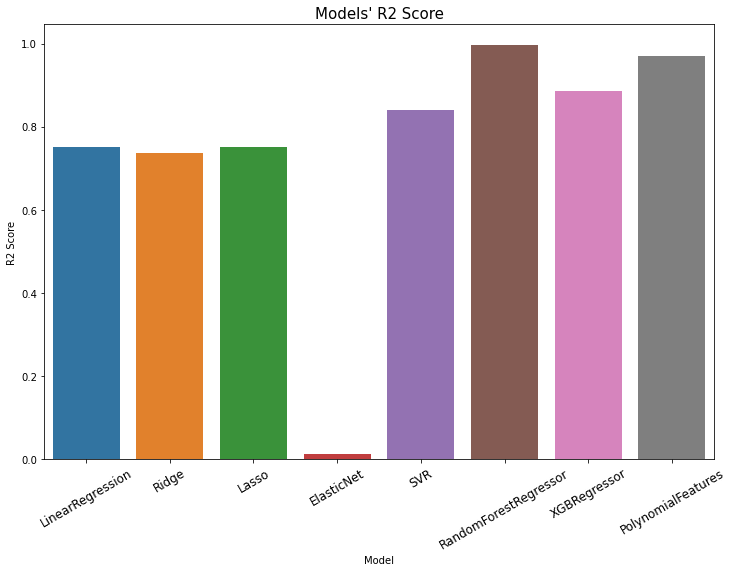

In [20]:
plt.figure(figsize=(12,8))
sns.barplot(x=models["Model"], y=models["R2 Score"])
plt.title("Models' R2 Score", size=15)
plt.xticks(rotation=30, size=12)
plt.show()

# Results

As we can see above the best model is the Random Forest Regressor and we are going to use it to calculate the areas that we want.

In [32]:
random_forest = RandomForestRegressor(n_estimators=100, n_jobs=-1)
random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)

In [60]:
# join the predictions with the actual values
df = pd.DataFrame({"Actual": y_test, "Predicted": predictions})

df.head()

,Actual,Predicted
31,21935.18713,21646.762872
32,22709.20348,21646.762872
64,42008.99934,42460.334250
65,42014.81084,42460.334250
97,111854.10850,106035.777849


In [61]:
# inner join df with pasture_data
df = df.join(pasture_data, how="inner")

df.head()

,Actual,Predicted,year,city_code,product_type,product,destinated_area,ano
31,21935.18713,21646.762872,2016-01-01,960b4f2c94a2fb2c,pasture,Livestock,21935.18713,42
32,22709.20348,21646.762872,2017-01-01,960b4f2c94a2fb2c,pasture,Livestock,22709.20348,43
64,42008.99934,42460.334250,2016-01-01,746cc42bfb8f6b62,pasture,Livestock,42008.99934,42
65,42014.81084,42460.334250,2017-01-01,746cc42bfb8f6b62,pasture,Livestock,42014.81084,43
97,111854.10850,106035.777849,2016-01-01,6cce2bf873870afc,pasture,Livestock,111854.10850,42


In [62]:
df[['year','city_code', 'product_type','product','destinated_area','Predicted']]

,year,city_code,product_type,product,destinated_area,Predicted
31,2016-01-01,960b4f2c94a2fb2c,pasture,Livestock,21935.18713,21646.762872
32,2017-01-01,960b4f2c94a2fb2c,pasture,Livestock,22709.20348,21646.762872
64,2016-01-01,746cc42bfb8f6b62,pasture,Livestock,42008.99934,42460.334250
65,2017-01-01,746cc42bfb8f6b62,pasture,Livestock,42014.81084,42460.334250
97,2016-01-01,6cce2bf873870afc,pasture,Livestock,111854.10850,106035.777849
...,...,...,...,...,...,...
4685,2017-01-01,64a227aa24370b17,pasture,Livestock,324427.34830,320790.262186
4717,2016-01-01,5b6072f8f6d37acc,pasture,Livestock,427013.72100,419029.936295
4718,2017-01-01,5b6072f8f6d37acc,pasture,Livestock,433669.56110,419029.936295
4750,2016-01-01,74d75dde6dc4a5ec,pasture,Livestock,164706.27780,153686.092459
